#### Script to produce combined ROC curve (Figure 1) for publication. Not to be shared online.

In [1]:
RANDOM_STATE = 40
TEST_SIZE = 0.2

CLASSIFIER_LABEL = 'pca_death_code'

PREPROCESS_DATA = False

CAP_DEMO_INSTANCE = 64
LEDER_DEMO_INSTANCE = 5

In [2]:
import pandas as pd
from joblib import dump, load

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

from helper import (pd_print, 
                    accuracy,
                    lemmatize_text,
                    summarise_gridsearch_classifier,
                    calibrate_random_forest, 
                    plot_calibration_curve,
                    plot_calibration_curve_easy_hard,
                    plot_roc_curve,
                    compute_all_metrics)

from explainability import (get_rf_feature_importances,
                            wordcloud,
                            run_tree_interpreter,
                            get_ti_feature_contributions_for_instance_i,
                            get_ti_feature_contributions_average)

import matplotlib.pyplot as plt
%matplotlib inline

import pickle

C:\Users\cm1788\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from cap_helper import *

print("Working with CAP prostate cancer data.")

if PREPROCESS_DATA:
    df = load_data()
    # Combine text from all feature columns into a single string column
    df = concatenate_feature_columns(df)
    # Link to dates of death:
    df = add_dates(df)
    # Link to reviewer Ids:
    df = add_reviewer_ids(df)
    # Convert all dates to be in units of months before/after death (Note: this regex is not foolproof)
    df = convert_dates_relative(df)  

    # The reviews are dominated by three authors:
    pd_print(get_reviewer_counts(df))
    
    stemmer = WordNetLemmatizer()
    X,y = df.combined, df[CLASSIFIER_LABEL]
    documents = lemmatize_text(X, stemmer)
    
    with open('cap_documents.pickle', 'wb') as ofile:
        pickle.dump(documents, ofile)
        
    with open('cap_labels.pickle', 'wb') as ofile:
        pickle.dump(y, ofile)
    
else:
    
    with open('cap_documents.pickle', 'rb') as ifile:
        documents = pickle.load(ifile)
        
    with open('cap_labels.pickle', 'rb') as ifile:
        y = pickle.load(ifile)

Working with CAP prostate cancer data.


In [4]:
print(len(y[y==1]))
print(len(y[y==2]))

1098
1512


In [5]:
X_train, X_test, y_train, y_test = train_test_split(documents, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [6]:
clf = load('models/cap_rf_gridsearch_090920.joblib')

# similar performance but with 1000 trees: (TI won't run!)
#clf = load('models/cap_rf_gridsearch_090920_2.joblib') 

#clf = load('../avon/grid_search_random_forest_bigrams_enforced.joblib')

In [7]:
summarise_gridsearch_classifier(clf)

Best score: 0.915
Best parameters set:
	clf__bootstrap: True
	clf__ccp_alpha: 0.0
	clf__class_weight: None
	clf__criterion: 'gini'
	clf__max_depth: 15
	clf__max_features: 0.2
	clf__max_leaf_nodes: None
	clf__max_samples: 0.6
	clf__min_impurity_decrease: 0.0
	clf__min_impurity_split: None
	clf__min_samples_leaf: 2
	clf__min_samples_split: 2
	clf__min_weight_fraction_leaf: 0.0
	clf__n_estimators: 500
	clf__n_jobs: None
	clf__oob_score: False
	clf__random_state: 40
	clf__verbose: 0
	clf__warm_start: False
	tfidf__norm: 'l2'
	tfidf__smooth_idf: True
	tfidf__sublinear_tf: False
	tfidf__use_idf: True
	vect__analyzer: 'word'
	vect__binary: False
	vect__decode_error: 'strict'
	vect__dtype: <class 'numpy.int64'>
	vect__encoding: 'utf-8'
	vect__input: 'content'
	vect__lowercase: True
	vect__max_df: 0.7
	vect__max_features: 1500
	vect__min_df: 5
	vect__ngram_range: (1, 2)
	vect__preprocessor: None
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "y

In [8]:
accuracy(clf, X_train, y_train, name='Train');
accuracy(clf, X_test, y_test);

Train Accuracy: 98.85%
Test Accuracy: 93.30%


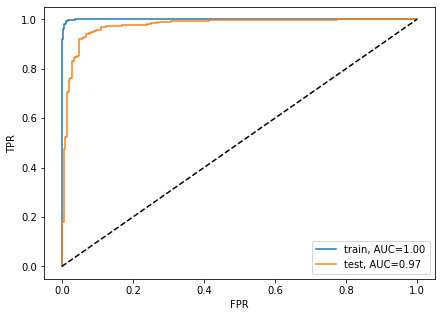

In [9]:
plot_roc_curve(clf, X_train, y_train, X_test, y_test, "train", "test", pos_label=2)

## LeDeR

In [11]:
from leder_helper import *

CLASSIFIER_LABEL_L = 'Poor_practice_flag'
TEST_SIZE = 0.2
RANDOM_STATE = 42

if PREPROCESS_DATA:

    print("Working with LeDeR disabilities data.")
    df = load_data()
    df = build_labels(df)
    df = concatenate_feature_columns(df)

    get_reviewer_counts(df)
    
    stemmer = WordNetLemmatizer()
    X_L,y_L = df.combined, df[CLASSIFIER_LABEL_L]
    documents_L = lemmatize_text(X_L, stemmer)
    
    with open('leder_documents.pickle', 'wb') as ofile:
        pickle.dump(documents_L, ofile)
        
    with open('leder_labels.pickle', 'wb') as ofile:
        pickle.dump(y_L, ofile)
    
else:
    
    with open('leder_documents.pickle', 'rb') as ifile:
        documents_L = pickle.load(ifile)
        
    with open('leder_labels.pickle', 'rb') as ifile:
        y_L = pickle.load(ifile)

In [12]:
clf2 = load('../avon/grid_search_random_forest_LeDeR_OPTIMISED_1.joblib')

In [13]:
X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(documents_L, 
                                                    y_L, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [14]:
accuracy(clf2, X_train_L, y_train_L, name='Train');
accuracy(clf2, X_test_L, y_test_L);

Train Accuracy: 72.99%
Test Accuracy: 63.81%


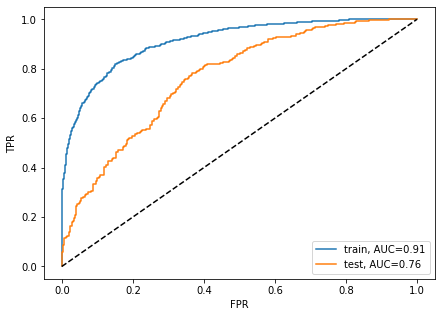

In [15]:
plot_roc_curve(clf2, X_train_L, y_train_L, X_test_L, y_test_L, "train", "test", pos_label=1)

## Produce single combined figure:

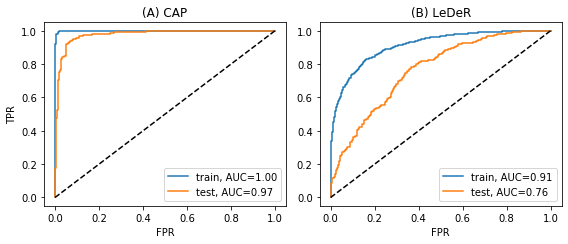

In [16]:
plt.figure(figsize=(8,3.5))

ax1 = plt.subplot(1,2,1)
plot_roc_curve(clf, X_train, y_train, X_test, y_test, "train", "test", pos_label=2, ax=ax1)
ax1.set_title('(A) CAP')

ax2 = plt.subplot(1,2,2)
plot_roc_curve(clf2, X_train_L, y_train_L, X_test_L, y_test_L, "train", "test", pos_label=1, ax=ax2)
ax2.set_ylabel('')
ax2.set_title('(B) LeDeR')

plt.tight_layout()
#plt.savefig("figure_1.jpg", dpi=300)

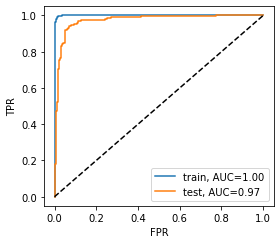

In [17]:
plt.figure(figsize=(4,3.5))

ax1 = plt.gca()
plot_roc_curve(clf, X_train, y_train, X_test, y_test, "train", "test", pos_label=2, ax=ax1)
#ax1.set_title('(A) CAP')


plt.tight_layout()
plt.savefig("figure_1.jpg", dpi=300)

## Now we prdocue Figure 2: word clouds for both classifiers.

This will be a 2x2 panel with single case and full dataset feature importances for both CAP and LeDeR. 


In [10]:
fimps = get_rf_feature_importances(clf2)
assert fimps.feature.is_unique
fimps.head(15)

NameError: name 'clf2' is not defined

In [11]:
wordcloud(fimps)

NameError: name 'fimps' is not defined

In [12]:
prediction, bias, contributions = run_tree_interpreter(clf, X_test)

In [13]:
ti_fimps_i = get_ti_feature_contributions_for_instance_i(CAP_DEMO_INSTANCE, contributions, clf)

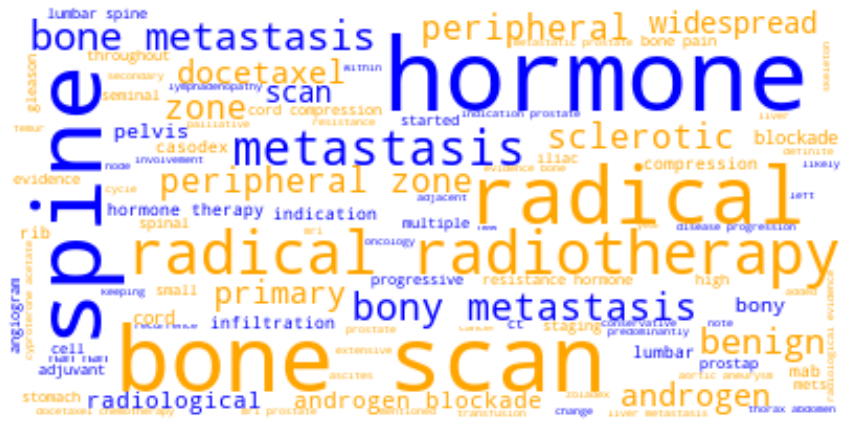

In [14]:
wordcloud(ti_fimps_i)

In [15]:
ti_fimps = get_ti_feature_contributions_average(contributions, clf)

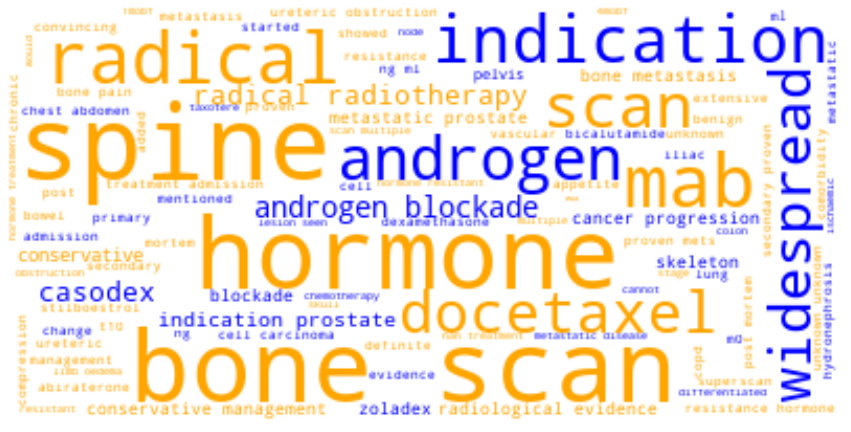

In [16]:
wordcloud(ti_fimps)

#### Now LeDeR:

In [22]:
df = load_data()
replace_coders = dict(zip(list(df.coder_atext.unique()) + ['normal karen'], ['coder_%d' %i for i in range(7)] + ['normal coder_7']))

In [23]:
prediction_L, bias_L, contributions_L = run_tree_interpreter(clf2, X_test_L)

In [24]:
ti_fimps_i_L = get_ti_feature_contributions_for_instance_i(LEDER_DEMO_INSTANCE, contributions_L, clf2)

In [25]:
ti_fimps_L = get_ti_feature_contributions_average(contributions_L, clf2)

In [26]:
ti_fimps_i_L['feature'] = [feat if feat not in replace_coders.keys() else replace_coders[feat] for feat in ti_fimps_i_L.feature]
ti_fimps_L['feature'] = [feat if feat not in replace_coders.keys() else replace_coders[feat] for feat in ti_fimps_L.feature]

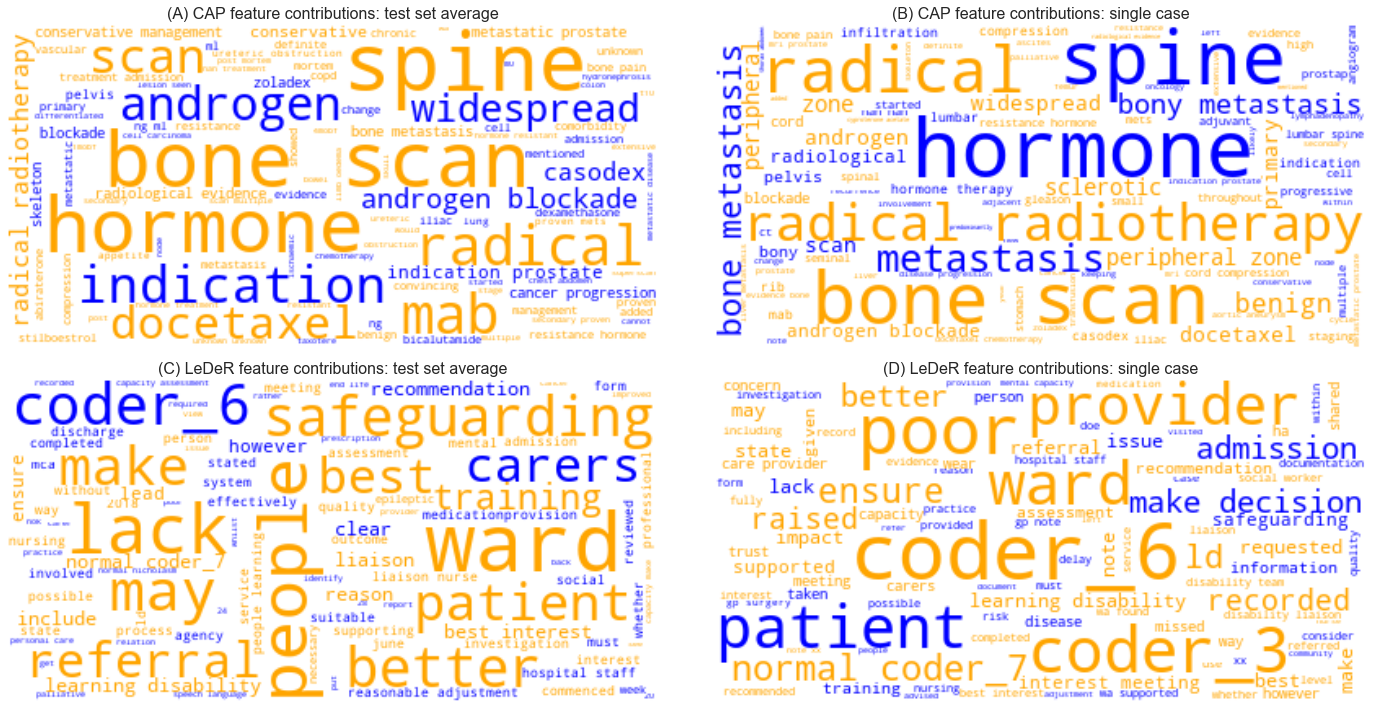

In [52]:
fst = 16

plt.figure(figsize=(20,10))

ax1 = plt.subplot(2,2,1)
wordcloud(ti_fimps, ax1)
ax1.set_title("(A) CAP feature contributions: test set average", fontsize=fst)
ax1.axis('on')
ax1.set_xticks([])
ax1.set_yticks([])


ax2 = plt.subplot(2,2,2)
wordcloud(ti_fimps_i, ax2)
#ax2.set_title("(B) CAP feature contributions: case %d" %CAP_DEMO_INSTANCE, fontsize=fst)
ax2.set_title("(B) CAP feature contributions: single case", fontsize=fst)
ax2.axis('on')
ax2.set_xticks([])
ax2.set_yticks([])


ax3 = plt.subplot(2,2,3)
wordcloud(ti_fimps_L, ax3)
ax3.set_title("(C) LeDeR feature contributions: test set average", fontsize=fst)
ax3.axis('on')
ax3.set_xticks([])
ax3.set_yticks([])


ax4 = plt.subplot(2,2,4)
wordcloud(ti_fimps_i_L, ax4)
#ax4.set_title("(D) LeDeR feature contributions: case %d" %LEDER_DEMO_INSTANCE, fontsize=fst)
ax4.set_title("(D) LeDeR feature contributions: single case", fontsize=fst)
ax4.axis('on')
ax4.set_xticks([])
ax4.set_yticks([])

plt.tight_layout()
#plt.savefig("figure_2.jpg", dpi=300)

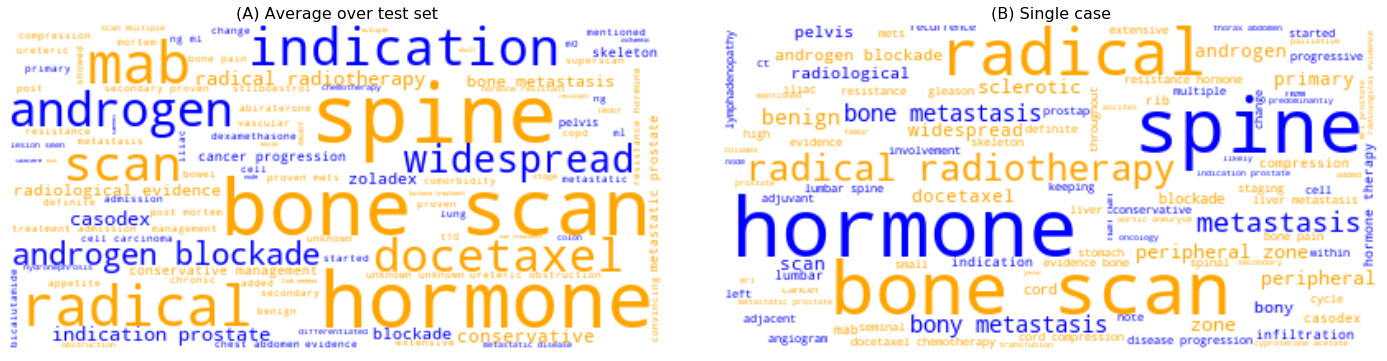

In [18]:
fst = 16

plt.figure(figsize=(20,5))

ax1 = plt.subplot(1,2,1)
wordcloud(ti_fimps, ax1)
ax1.set_title("(A) Average over test set", fontsize=fst)
ax1.axis('off')
ax1.set_xticks([])
ax1.set_yticks([])


ax2 = plt.subplot(1,2,2)
wordcloud(ti_fimps_i, ax2)
#ax2.set_title("(B) CAP feature contributions: case %d" %CAP_DEMO_INSTANCE, fontsize=fst)
ax2.set_title("(B) Single case", fontsize=fst)
ax2.axis('off')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.savefig("figure_2.jpg", dpi=300)

### INterpretable vignette (to match case form Figure 2 plot):

In [44]:
from interpretable_pdf import InterpretablePDF
from cap_helper import *

num=64

df = load_data()
# Combine text from all feature columns into a single string column
df = concatenate_feature_columns(df)
# Link to dates of death:
df = add_dates(df)
# Link to reviewer Ids:
df = add_reviewer_ids(df)
# Convert all dates to be in units of months before/after death (Note: this regex is not foolproof)
df = convert_dates_relative(df) 

original_data = df.loc[y_test.index[num]]
feature_columns = df.columns[2:27]

ipdf = InterpretablePDF(clf, X_test, y_test, feature_columns, contributions=contributions)
#ipdf.create_pdf(CAP_DEMO_INSTANCE, original_data, "test.pdf")

ipdf.create_pdf(num, original_data, "test_%d.pdf" %num)

## Using LIME:

In [29]:
import fatf
import fatf.transparency.predictions.surrogate_explainers as fatf_surrogates
import fatf.vis.lime as fatf_vis_lime
from pprint import pprint

20-Sep-11 13:49:11 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [30]:
fatf.setup_random_seed(RANDOM_STATE)

20-Sep-11 13:49:11 fatf         INFO     Seeding RNGs using the input parameter.
20-Sep-11 13:49:11 fatf         INFO     Seeding RNGs with 42.


In [31]:
X = clf2.best_estimator_['vect'].fit_transform(documents_L).toarray()

In [32]:
X = clf2.best_estimator_['tfidf'].fit_transform(X).toarray()

In [33]:
X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(X, 
                                                    y_L, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [34]:
lime = fatf_surrogates.TabularBlimeyLime(
    X_test_L,
    clf2.best_estimator_['clf'],
    feature_names=clf2.best_estimator_['vect'].get_feature_names(),
    class_names=['good', 'poor practice'])

In [35]:
index_to_explain = 42

# Explain an instance
lime_explanation = lime.explain_instance(
    X_test_L[index_to_explain, :], samples_number=500)

# Display the textual explanation
#pprint(lime_explanation)

20-Sep-11 13:49:29 fatf.transparency.predictions.surrogate_explainers INFO     Selecting 1500 features with highest weights.


In [36]:
fimps_lime = pd.DataFrame()
fimps_lime['feature'] = clf2.best_estimator_['vect'].get_feature_names()

In [37]:
fimps_lime['contribution'] = [lime_explanation['poor practice'][key] for key in lime_explanation['poor practice'].keys()]

In [38]:
fimps_lime['magnitude'] = [np.abs(c) for c in fimps_lime['contribution']]

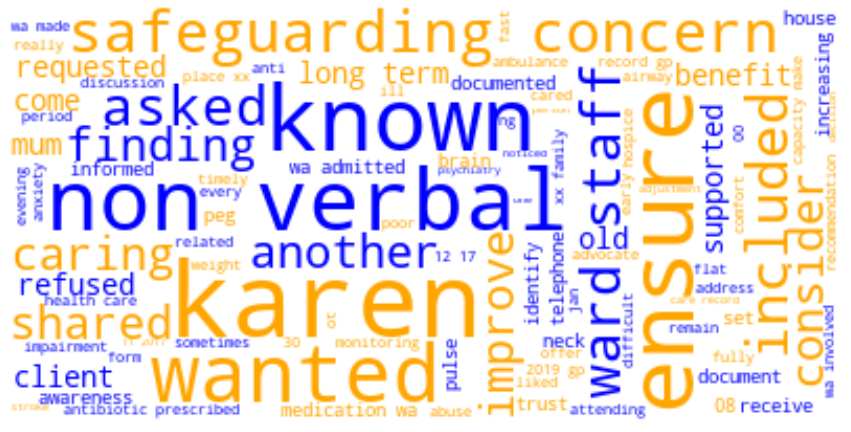

In [39]:
wordcloud(fimps_lime)

## Get only the top XX features for LIME plot:

In [40]:
TOP_N = 20
top_features = fimps_lime.sort_values('magnitude', ascending=False).head(TOP_N)

In [41]:
explanation = lime_explanation['poor practice']

In [42]:
short_expalanation = {'poor practice': dict()}

for key in explanation.keys():
    
    for feat in top_features.feature:
        if feat == key.split('*')[1]:
            short_expalanation['poor practice'][key] = lime_explanation['poor practice'][key]

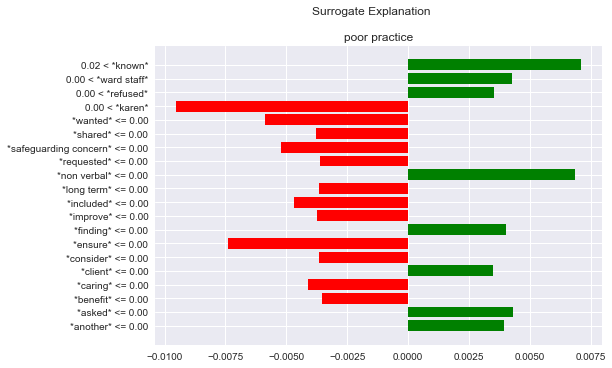

In [43]:
fatf_vis_lime.plot_lime(short_expalanation);

In [12]:
from leder_helper import *

CLASSIFIER_LABEL_L = 'Poor_practice_flag'
TEST_SIZE = 0.2
RANDOM_STATE = 42



print("Working with LeDeR disabilities data.")
df = load_data()

df = concatenate_feature_columns(df)
# Link to dates of death:
df = build_labels(df)
df = concatenate_feature_columns(df)


Working with LeDeR disabilities data.


KeyboardInterrupt: 

In [9]:
poor_practice_indicators = [col for col in df.columns if ('Poor' in col and 'atext' not in col)]

In [11]:
len(poor_practice_indicators)

9

In [5]:
len(df)

4379

In [6]:
len(df.columns)

1177

In [14]:
text_columns = [col for col in df.columns if col not in get_practice_columns(df) and 'atext' in col]

In [15]:
text_columns = [t.split('_atext')[0] for t in text_columns]

In [16]:
text_columns

['AAA_screening',
 'AAA_screening_no',
 'AAA_screening_yes',
 'AP_agencies',
 'AP_completed_DNACPR',
 'AP_completed_EOL_care',
 'AP_completed_LD_awareness',
 'AP_completed_MCA',
 'AP_completed_agencies',
 'AP_completed_care_coordination',
 'AP_completed_documentation',
 'AP_completed_family',
 'AP_completed_other',
 'AP_completed_reasonable_adjustments',
 'AP_completed_role_paid_carers',
 'AP_person',
 'AP_raised_DNACPR',
 'AP_raised_EOL_care',
 'AP_raised_LD_awareness',
 'AP_raised_MCA',
 'AP_raised_agencies',
 'AP_raised_care_coordination',
 'AP_raised_documentation',
 'AP_raised_family',
 'AP_raised_other',
 'AP_raised_reasonable_adjustments',
 'AP_raised_role_paid_carers',
 'Absences_1_to_4_per_month',
 'Absences_frequency',
 'Accident_incident',
 'Accommodation',
 'Accommodation_type',
 'Acm_Change_1Yr_Num',
 'Acm_Change_1Yr_one',
 'Acm_Change_1Yr_over_three',
 'Acm_Change_1Yr_three',
 'Acm_Change_1Yr_two',
 'Acm_Iss_1Yr',
 'Acm_Iss_Evr',
 'Acm_Multi_Changes',
 'Acm_TOD_5years_and

In [11]:
text_columns[0].split('_atext')

['AAA_screening', '']

In [3]:
from cap_helper import *

df = load_data()
# Combine text from all feature columns into a single string column
df = concatenate_feature_columns(df)
# Link to dates of death:
df = add_dates(df)
# Link to reviewer Ids:
df = add_reviewer_ids(df)
# Convert all dates to be in units of months before/after death (Note: this regex is not foolproof)
df = convert_dates_relative(df)  


In [4]:
cols = df.columns
cols = cols[2:27]  # This excludes 'cp1id', 'cp1vig date completed', 'cp1vig summary'
cols = [c for c in cols if 'palliative' not in c]  # remove palliative column because confounded

In [6]:
feats = [c.split('cp1vig ')[1] for c in cols]

In [7]:
featsts

['gleason',
 'clinical stage',
 'path stage',
 'comorbidity',
 'primaries',
 'diagnosis psa',
 'local spread',
 'diag mets',
 'treatment',
 'hormones',
 'mab',
 'orchidectomy',
 'chemotherapy',
 'complications',
 'serial psa',
 'testosterone',
 'prog mets',
 'progression',
 'recurrence',
 'treat comorb',
 'final symptoms',
 'final consult',
 'ds1500',
 'post mortem']

In [12]:
y_test_L.iloc[LEDER_DEMO_INSTANCE]

True

In [16]:
clf2.predict_proba(X_test_L)[LEDER_DEMO_INSTANCE,1]

0.407433563702025

In [17]:
y_test_L

175      True
3659    False
3702     True
2702    False
3084    False
        ...  
3364     True
2450    False
2903    False
291     False
1966     True
Name: Poor_practice_flag, Length: 876, dtype: bool